In [1]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


def ad_hoc_data(training_size, test_size, n, gap, PLOT_DATA):
    class_labels = [r'A', r'B']
    if n == 2:
        N = 100
    elif n == 3:
        N = 20   # courseness of data seperation

    label_train = np.zeros(2*(training_size+test_size))
    sample_train = []
    sampleA = [[0 for x in range(n)] for y in range(training_size+test_size)]
    sampleB = [[0 for x in range(n)] for y in range(training_size+test_size)]

    sample_Total = [[[0 for x in range(N)] for y in range(N)] for z in range(N)]

    interactions = np.transpose(np.array([[1, 0], [0, 1], [1, 1]]))

    steps = 2*np.pi/N

    sx = np.array([[0, 1], [1, 0]])
    X = np.asmatrix(sx)
    sy = np.array([[0, -1j], [1j, 0]])
    Y = np.asmatrix(sy)
    sz = np.array([[1, 0], [0, -1]])
    Z = np.asmatrix(sz)
    J = np.array([[1, 0], [0, 1]])
    J = np.asmatrix(J)
    H = np.array([[1, 1], [1, -1]])/np.sqrt(2)
    H2 = np.kron(H, H)
    H3 = np.kron(H, H2)
    H = np.asmatrix(H)
    H2 = np.asmatrix(H2)
    H3 = np.asmatrix(H3)

    f = np.arange(2**n)

    my_array = [[0 for x in range(n)] for y in range(2**n)]

    for arindex in range(len(my_array)):
        temp_f = bin(f[arindex])[2:].zfill(n)
        for findex in range(n):
            my_array[arindex][findex] = int(temp_f[findex])

    my_array = np.asarray(my_array)
    my_array = np.transpose(my_array)

    # Define decision functions
    maj = (-1)**(2*my_array.sum(axis=0) > n)
    parity = (-1)**(my_array.sum(axis=0))
    dict1 = (-1)**(my_array[0])
    if n == 2:
        D = np.diag(parity)
    elif n == 3:
        D = np.diag(maj)

    Basis = np.random.random((2**n, 2**n)) + 1j*np.random.random((2**n, 2**n))
    Basis = np.asmatrix(Basis).getH()*np.asmatrix(Basis)

    [S, U] = np.linalg.eig(Basis)

    idx = S.argsort()[::-1]
    S = S[idx]
    U = U[:, idx]

    M = (np.asmatrix(U)).getH()*np.asmatrix(D)*np.asmatrix(U)

    psi_plus = np.transpose(np.ones(2))/np.sqrt(2)
    psi_0 = 1
    for k in range(n):
        psi_0 = np.kron(np.asmatrix(psi_0), np.asmatrix(psi_plus))

    sample_total_A = []
    sample_total_B = []
    sample_total_void = []
    if n == 2:
        for n1 in range(N):
            for n2 in range(N):
                x1 = steps*n1
                x2 = steps*n2
                phi = x1*np.kron(Z, J) + x2*np.kron(J, Z) + (np.pi-x1)*(np.pi-x2)*np.kron(Z, Z)
                Uu = scipy.linalg.expm(1j*phi)
                psi = np.asmatrix(Uu)*H2*np.asmatrix(Uu)*np.transpose(psi_0)
                temp = np.asscalar(np.real(psi.getH()*M*psi))
                if temp > gap:
                    sample_Total[n1][n2] = +1
                elif temp < -gap:
                    sample_Total[n1][n2] = -1
                else:
                    sample_Total[n1][n2] = 0

        # Now sample randomly from sample_Total a number of times training_size+testing_size
        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            if sample_Total[draw1][draw2] == +1:
                sampleA[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
                tr += 1

        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            if sample_Total[draw1][draw2] == -1:
                sampleB[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
                tr += 1

        sample_train = [sampleA, sampleB]

        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:
            img = plt.imshow(np.asmatrix(sample_Total).T, interpolation='nearest',
                             origin='lower', cmap='copper', extent=[0, 2*np.pi, 0, 2*np.pi])
            plt.show()
            fig2 = plt.figure()
            for k in range(0, 2):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Ad-hoc Data")
            plt.show()

    elif n == 3:
        for n1 in range(N):
            for n2 in range(N):
                for n3 in range(N):
                    x1 = steps*n1
                    x2 = steps*n2
                    x3 = steps*n3
                    phi = x1*np.kron(np.kron(Z, J), J) + x2*np.kron(np.kron(J, Z), J) + x3*np.kron(np.kron(J, J), Z) + \
                        (np.pi-x1)*(np.pi-x2)*np.kron(np.kron(Z, Z), J)+(np.pi-x2)*(np.pi-x3)*np.kron(np.kron(J, Z), Z) + \
                        (np.pi-x1)*(np.pi-x3)*np.kron(np.kron(Z, J), Z)
                    Uu = scipy.linalg.expm(1j*phi)
                    psi = np.asmatrix(Uu)*H3*np.asmatrix(Uu)*np.transpose(psi_0)
                    temp = np.asscalar(np.real(psi.getH()*M*psi))
                    if temp > gap:
                        sample_Total[n1][n2][n3] = +1
                        sample_total_A.append([n1, n2, n3])
                    elif temp < -gap:
                        sample_Total[n1][n2][n3] = -1
                        sample_total_B.append([n1, n2, n3])
                    else:
                        sample_Total[n1][n2][n3] = 0
                        sample_total_void.append([n1, n2, n3])

        # Now sample randomly from sample_Total a number of times training_size+testing_size
        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            draw3 = np.random.choice(N)
            if sample_Total[draw1][draw2][draw3] == +1:
                sampleA[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N, 2*np.pi*draw3/N]
                tr += 1

        tr = 0
        while tr < (training_size+test_size):
            draw1 = np.random.choice(N)
            draw2 = np.random.choice(N)
            draw3 = np.random.choice(N)
            if sample_Total[draw1][draw2][draw3] == -1:
                sampleB[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N, 2*np.pi*draw3/N]
                tr += 1

        sample_train = [sampleA, sampleB]

        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:

            sample_total_A = np.asarray(sample_total_A)
            sample_total_B = np.asarray(sample_total_B)
            x1 = sample_total_A[:, 0]
            y1 = sample_total_A[:, 1]
            z1 = sample_total_A[:, 2]

            x2 = sample_total_B[:, 0]
            y2 = sample_total_B[:, 1]
            z2 = sample_total_B[:, 2]

            fig1 = plt.figure()
            ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
            ax1.scatter(x1, y1, z1, c='#8A360F')
            plt.show()
        #
            fig2 = plt.figure()
            ax2 = fig2.add_subplot(1, 1, 1, projection='3d')
            ax2.scatter(x2, y2, z2, c='#683FC8')
            plt.show()

            sample_training_A = training_input['A']
            sample_training_B = training_input['B']

            x1 = sample_training_A[:, 0]
            y1 = sample_training_A[:, 1]
            z1 = sample_training_A[:, 2]

            x2 = sample_training_B[:, 0]
            y2 = sample_training_B[:, 1]
            z2 = sample_training_B[:, 2]

            fig1 = plt.figure()
            ax1 = fig1.add_subplot(1, 1, 1, projection='3d')
            ax1.scatter(x1, y1, z1, c='#8A360F')
            ax1.scatter(x2, y2, z2, c='#683FC8')
            plt.show()

    return sample_Total, training_input, test_input, class_labels


def sample_ad_hoc_data(sample_Total, test_size, n):
    tr = 0

    class_labels = [r'A', r'B']  # copied from ad_hoc_data()
    if n == 2:
        N = 100
    elif n == 3:
        N = 20

    label_train = np.zeros(2*test_size)
    sampleA = [[0 for x in range(n)] for y in range(test_size)]
    sampleB = [[0 for x in range(n)] for y in range(test_size)]
    while tr < (test_size):
        draw1 = np.random.choice(N)
        draw2 = np.random.choice(N)
        if sample_Total[draw1][draw2] == +1:
            sampleA[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
            tr += 1

    tr = 0
    while tr < (test_size):
        draw1 = np.random.choice(N)
        draw2 = np.random.choice(N)
        if sample_Total[draw1][draw2] == -1:
            sampleB[tr] = [2*np.pi*draw1/N, 2*np.pi*draw2/N]
            tr += 1
    sample_train = [sampleA, sampleB]
    for lindex in range(test_size):
        label_train[lindex] = 0
    for lindex in range(test_size):
        label_train[test_size+lindex] = 1
    label_train = label_train.astype(int)
    sample_train = np.reshape(sample_train, (2 * test_size, n))
    test_input = {key: (sample_train[label_train == k, :])[:] for k, key in enumerate(class_labels)}
    return test_input


def Breast_cancer(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B']
    data, target = datasets.load_breast_cancer(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=0.3, random_state=12)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Breast cancer dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels


def Digits(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B', r'C', r'D', r'E', r'F', r'G', r'H', r'I', r'J']
    data = datasets.load_digits()
    sample_train, sample_test, label_train, label_test = train_test_split(
        data.data, data.target, test_size=0.3, random_state=22)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 9):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Digits dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels


def Iris(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B', r'C']
    data, target = datasets.load_iris(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=1, random_state=42)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)

    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("Iris dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels


def Wine(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B', r'C']

    data, target = datasets.load_wine(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=test_size, random_state=7)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)
    # Pick training size number of samples from each distro
    training_input = {key: (sample_train[label_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (sample_train[label_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 3):
            plt.scatter(sample_train[label_train == k, 0][:training_size],
                        sample_train[label_train == k, 1][:training_size])

        plt.title("PCA dim. reduced Wine dataset")
        plt.show()

    return sample_train, training_input, test_input, class_labels


def Gaussian(training_size, test_size, n, PLOT_DATA):
    sigma = 1
    if n == 2:
        class_labels = [r'A', r'B']
        label_train = np.zeros(2*(training_size+test_size))
        sample_train = []
        sampleA = [[0 for x in range(n)] for y in range(training_size+test_size)]
        sampleB = [[0 for x in range(n)] for y in range(training_size+test_size)]
        randomized_vector1 = np.random.randint(2, size=n)
        randomized_vector2 = (randomized_vector1+1) % 2
        for tr in range(training_size+test_size):
            for feat in range(n):
                if randomized_vector1[feat] == 0:
                    sampleA[tr][feat] = np.random.normal(-1/2, sigma, None)
                elif randomized_vector1[feat] == 1:
                    sampleA[tr][feat] = np.random.normal(1/2, sigma, None)
                else:
                    print('Nope')

                if randomized_vector2[feat] == 0:
                    sampleB[tr][feat] = np.random.normal(-1/2, sigma, None)
                elif randomized_vector2[feat] == 1:
                    sampleB[tr][feat] = np.random.normal(1/2, sigma, None)
                else:
                    print('Nope')

        sample_train = [sampleA, sampleB]
        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (2*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:
            fig1 = plt.figure()
            for k in range(0, 2):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Gaussians")
            plt.show()

        return sample_train, training_input, test_input, class_labels
    elif n == 3:
        class_labels = [r'A', r'B', r'C']
        label_train = np.zeros(3*(training_size+test_size))
        sample_train = []
        sampleA = [[0 for x in range(n)] for y in range(training_size+test_size)]
        sampleB = [[0 for x in range(n)] for y in range(training_size+test_size)]
        sampleC = [[0 for x in range(n)] for y in range(training_size+test_size)]
        randomized_vector1 = np.random.randint(3, size=n)
        randomized_vector2 = (randomized_vector1+1) % 3
        randomized_vector3 = (randomized_vector2+1) % 3
        for tr in range(training_size+test_size):
            for feat in range(n):
                if randomized_vector1[feat] == 0:
                    sampleA[tr][feat] = np.random.normal(2*1*np.pi/6, sigma, None)
                elif randomized_vector1[feat] == 1:
                    sampleA[tr][feat] = np.random.normal(2*3*np.pi/6, sigma, None)
                elif randomized_vector1[feat] == 2:
                    sampleA[tr][feat] = np.random.normal(2*5*np.pi/6, sigma, None)
                else:
                    print('Nope')

                if randomized_vector2[feat] == 0:
                    sampleB[tr][feat] = np.random.normal(2*1*np.pi/6, sigma, None)
                elif randomized_vector2[feat] == 1:
                    sampleB[tr][feat] = np.random.normal(2*3*np.pi/6, sigma, None)
                elif randomized_vector2[feat] == 2:
                    sampleB[tr][feat] = np.random.normal(2*5*np.pi/6, sigma, None)
                else:
                    print('Nope')

                if randomized_vector3[feat] == 0:
                    sampleC[tr][feat] = np.random.normal(2*1*np.pi/6, sigma, None)
                elif randomized_vector3[feat] == 1:
                    sampleC[tr][feat] = np.random.normal(2*3*np.pi/6, sigma, None)
                elif randomized_vector3[feat] == 2:
                    sampleC[tr][feat] = np.random.normal(2*5*np.pi/6, sigma, None)
                else:
                    print('Nope')

        sample_train = [sampleA, sampleB, sampleC]
        for lindex in range(training_size+test_size):
            label_train[lindex] = 0
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+lindex] = 1
        for lindex in range(training_size+test_size):
            label_train[training_size+test_size+training_size+test_size+lindex] = 2
        label_train = label_train.astype(int)
        sample_train = np.reshape(sample_train, (3*(training_size+test_size), n))
        training_input = {key: (sample_train[label_train == k, :])[:training_size]
                          for k, key in enumerate(class_labels)}
        test_input = {key: (sample_train[label_train == k, :])[training_size:(
            training_size+test_size)] for k, key in enumerate(class_labels)}

        if PLOT_DATA:
            fig1 = plt.figure()
            for k in range(0, 3):
                plt.scatter(sample_train[label_train == k, 0][:training_size],
                            sample_train[label_train == k, 1][:training_size])

            plt.title("Gaussians")
            plt.show()

        return sample_train, training_input, test_input, class_labels
    else:
        print("Gaussian presently only supports 2 or 3 qubits")

In [2]:
import pandas as pd
trainingData = pd.read_csv('kyc.csv')
print (trainingData)
print (trainingData.describe())
print (trainingData.columns)
print (trainingData.shape)


     applicationNumber         name        surname    FatherOrSpouseName  \
0                    1      Rebecca          Olsen          Andrew Olsen   
1                    2     Benjamin        Gardner         Tanya Gardner   
2                    3          Dr.  Jason Mendoza  Teresa Jason Mendoza   
3                    4       George         Thomas        Russell Thomas   
4                    5         Jody         Palmer          James Palmer   
..                 ...          ...            ...                   ...   
995                996      Suzanne           Hunt          Gregory Hunt   
996                997       Debbie      Middleton       Chris Middleton   
997                998  Christopher      Schneider       Kathy Schneider   
998                999      Russell          Grant           Kelly Grant   
999               1000      Melanie        Schultz          Carl Schultz   

    FatherSpouseIndicator Gender MaritalStatus        DOB Nationality  \
0             

In [3]:


from qiskit import BasicAer
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.feature_maps import SecondOrderExpansion

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log


ModuleNotFoundError: No module named 'qiskit.aqua.input'

In [3]:
feature_dim=2 # we support feature_dim 2 or 3
#sample_Total - a series of 0,1 and -1
sample_Total=[[0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0], 
              [0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0], [0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0], [-1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1], [-1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1], [-1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1], [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0], [1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1], [0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1], [-1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [-1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [-1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1], [1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1], [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [-1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [-1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [-1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [-1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1], [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1], [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1], [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0], [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0], [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1], [0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1], [1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1], [1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [-1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [-1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1], [-1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1], [-1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1], [0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1], [1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1], [1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, -1], [1, 1, 1, 1, 0, 0, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, 0], [1, 1, 1, 1, 1, 0, 0, 0, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 1, 1], [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 1, 1], [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, 0, 0, 1, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, -1, -1, 0, 0, 0, 1, 1, 1, 1], [-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, 0, 0, 0, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1], [-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, -1, 0, 0, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1], [-1, -1, 0, 0, 0, 1, 0, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, -1, 0, 0, 0, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, -1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0], [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, -1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1, 0, -1, -1, -1, -1, -1, -1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 0, 0, 0]]
#{'A': 0, 'B': 1}

#We have taken two dimensions/features - Age and GrossAnnualIncome and formed two classes 
#of interesting (Good) and not so interesting (Bad)              
training_input = {'B': [[86.0, 2088139.0],
  [68.0, 927650.0],
  [71.0, 1133323.0],
  [68.0, 859230.0],
  [75.0, 1668323.0],
  [70.0, 104659.0],
  [88.0, 2032140.0],
  [60.0, 1200924.0],
  [86.0, 1709721.0],
  [71.0, 1557657.0],
  [62.0, 739554.0],
  [70.0, 2297395.0],
  [75.0, 1572765.0],
  [62.0, 561837.0],
  [85.0, 2001166.0],
  [68.0, 1453153.0],
  [68.0, 2079213.0],
  [54.0, 1821207.5204705882],
  [81.0, 2149082.0],
  [66.0, 1121032.0],
  [78.0, 887854.0],
  [70.0, 406577.0],
  [53.0, 863881.8256470588],
  [72.0, 1728032.0],
  [70.0, 1598777.0],
  [69.0, 1559767.0],
  [60.0, 2270881.0],
  [64.0, 1109393.0],
  [85.0, 1245050.0],
  [53.0, 2403507.825647059],
  [65.0, 1669655.0],
  [51.0, 2251381.436],
  [60.0, 410733.0],
  [66.0, 1738102.0],
  [81.0, 925196.0],
  [60.0, 1696920.0],
  [57.0, 997542.6049411764],
  [55.0, 1171073.2152941176],
  [76.0, 1443414.0],
  [88.0, 1860528.0],
  [53.0, 1186336.8256470591],
  [78.0, 1041707.0],
  [66.0, 621639.0],
  [65.0, 1811310.0],
  [62.0, 401691.0],
  [68.0, 1862822.0],
  [71.0, 2259156.0],
  [54.0, 1307998.5204705882],
  [65.0, 765190.0],
  [67.0, 1820860.0],
  [61.0, 2015099.0],
  [87.0, 2207639.0],
  [85.0, 235240.0],
  [73.0, 648646.0],
  [54.0, 1974017.5204705882],
  [82.0, 1727780.0],
  [66.0, 562020.0],
  [78.0, 860420.0],
  [53.0, 1984459.8256470591],
  [61.0, 1745886.0],
  [72.0, 1928973.0],
  [54.0, 2402346.5204705885],
  [82.0, 1968270.0],
  [51.0, 1798283.436],
  [77.0, 1513510.0],
  [61.0, 1871448.0],
  [60.0, 1396098.0],
  [85.0, 1195902.0],
  [70.0, 1896744.0],
  [68.0, 2061966.0],
  [65.0, 1570247.0],
  [67.0, 1713076.0],
  [86.0, 617036.0],
  [72.0, 1349583.0],
  [82.0, 701447.0],
  [81.0, 675807.0],
  [51.0, 1779859.436],
  [64.0, 1747625.0],
  [59.0, 2293732.9945882354],
  [81.0, 1398855.0],
  [74.0, 1038926.0],
  [84.0, 2428337.0],
  [60.0, 1084833.0],
  [88.0, 1503015.0],
  [74.0, 235625.0],
  [58.0, 1031490.2997647059],
  [87.0, 1548341.0],
  [75.0, 307918.0],
  [76.0, 1894550.0],
  [51.0, 1766710.436],
  [82.0, 823199.0],
  [60.0, 719574.0],
  [64.0, 1182794.0],
  [83.0, 1407232.0],
  [58.0, 1053720.2997647058],
  [78.0, 1055105.0],
  [79.0, 2373248.0],
  [63.0, 1166688.0],
  [78.0, 291269.0],
  [75.0, 273849.0],
  [74.0, 1863432.0],
  [61.0, 1175612.0],
  [56.0, 949239.910117647],
  [75.0, 1127527.0],
  [55.0, 1521317.2152941176],
  [83.0, 2184900.0],
  [73.0, 1802451.0],
  [54.0, 2055196.5204705882],
  [85.0, 141436.0],
  [65.0, 602889.0],
  [52.0, 1478432.1308235298],
  [52.0, 1932288.1308235298],
  [73.0, 1618065.0],
  [51.0, 803754.436],
  [61.0, 342445.0],
  [65.0, 887685.0],
  [61.0, 112963.0],
  [56.0, 1428873.9101176471],
  [88.0, 110706.0],
  [59.0, 1502091.9945882354],
  [61.0, 148733.0],
  [55.0, 1725776.2152941176],
  [58.0, 1059258.2997647058],
  [88.0, 2146677.0],
  [52.0, 2175977.130823529],
  [81.0, 1358684.0],
  [83.0, 1637336.0],
  [64.0, 2083598.0],
  [86.0, 536071.0],
  [51.0, 1532941.436],
  [85.0, 557082.0],
  [78.0, 455491.0],
  [68.0, 1699009.0],
  [71.0, 821790.0],
  [52.0, 2260300.130823529],
  [81.0, 1628719.0],
  [57.0, 1618689.6049411763],
  [71.0, 1821316.0],
  [72.0, 1880805.0],
  [84.0, 83550.0],
  [74.0, 804333.0],
  [55.0, 2435196.2152941176],
  [77.0, 539710.0],
  [54.0, 1287183.5204705882],
  [81.0, 1793467.0],
  [81.0, 2023226.0],
  [56.0, 937728.910117647],
  [51.0, 1649173.436],
  [87.0, 1497852.0],
  [76.0, 1032737.0],
  [67.0, 1817827.0],
  [64.0, 691010.0],
  [72.0, 2114783.0],
  [86.0, 2168556.0],
  [62.0, 2044186.0],
  [70.0, 1916777.0],
  [60.0, 1511986.0],
  [73.0, 1240878.0],
  [62.0, 1775213.0],
  [64.0, 2349062.0],
  [87.0, 1852563.0],
  [79.0, 2268099.0],
  [68.0, 1717043.0],
  [77.0, 1692636.0],
  [65.0, 1607491.0],
  [58.0, 2196839.299764706],
  [66.0, 1365891.0],
  [82.0, 67499.0],
  [74.0, 1473332.0],
  [86.0, 173875.0],
  [60.0, 2284715.0],
  [73.0, 2227195.0],
  [61.0, 2043131.0],
  [84.0, 609694.0],
  [52.0, 1012073.1308235296],
  [70.0, 772613.0],
  [64.0, 2210298.0],
  [75.0, 244064.0],
  [54.0, 1539828.5204705882],
  [70.0, 1151256.0],
  [75.0, 2171741.0],
  [83.0, 2170250.0],
  [57.0, 2335669.6049411763],
  [71.0, 1147963.0],
  [61.0, 2214072.0],
  [82.0, 1540631.0],
  [62.0, 1365009.0],
  [59.0, 2228542.9945882354],
  [76.0, 1645349.0],
  [67.0, 1587497.0],
  [78.0, 643096.0],
  [76.0, 1721453.0],
  [68.0, 950093.0],
  [81.0, 807627.0],
  [86.0, 1181131.0],
  [84.0, 553124.0],
  [76.0, 1330283.0],
  [52.0, 1466091.1308235298],
  [70.0, 282382.0],
  [64.0, 1622706.0],
  [63.0, 1592305.0],
  [55.0, 1321277.2152941176],
  [60.0, 1248979.0],
  [86.0, 156015.0],
  [63.0, 807182.0],
  [85.0, 2387708.0],
  [80.0, 1602908.0],
  [63.0, 2281216.0],
  [83.0, 1402393.0],
  [78.0, 622463.0],
  [79.0, 176860.0],
  [62.0, 1272747.0],
  [72.0, 741442.0],
  [85.0, 581336.0],
  [60.0, 427566.0],
  [60.0, 323985.0],
  [67.0, 461656.0],
  [53.0, 2220121.825647059],
  [77.0, 1387962.0],
  [58.0, 2172295.299764706],
  [63.0, 121815.0],
  [69.0, 360589.0],
  [56.0, 1880403.9101176471],
  [85.0, 2305692.0],
  [51.0, 1693089.436],
  [66.0, 1364296.0],
  [82.0, 1458809.0],
  [52.0, 943694.1308235296],
  [63.0, 412585.0],
  [61.0, 924591.0],
  [77.0, 1213806.0],
  [56.0, 2130789.9101176467],
  [71.0, 1974327.0],
  [58.0, 1990471.2997647056],
  [62.0, 2431145.0],
  [71.0, 2096240.0],
  [71.0, 1376852.0],
  [63.0, 893159.0],
  [64.0, 846079.0],
  [64.0, 894611.0],
  [80.0, 629616.0],
  [71.0, 1718584.0],
  [72.0, 1263399.0],
  [58.0, 2147241.299764706],
  [56.0, 2427227.9101176467],
  [71.0, 1328031.0],
  [52.0, 1632908.1308235298]],
 'G': [[42.0, 2709112.1825882355],
  [42.0, 3724968.1825882364],
  [42.0, 3716432.1825882364],
  [22.0, 3402745.286117647],
  [44.0, 5300792.572235294],
  [22.0, 3530238.286117647],
  [45.0, 3785055.2670588233],
  [43.0, 3300664.877411765]]}
#{'A': 0, 'B': 1}

test_input = {'B': [[64.0, 894611.0],
  [80.0, 629616.0],
  [71.0, 1718584.0],
  [72.0, 1263399.0],
  [58.0, 2147241.299764706],
  [56.0, 2427227.9101176467],
  [71.0, 1328031.0],
  [52.0, 1632908.1308235298]],
              'G': [[42.0, 3709112.1825882355],
  [42.0, 4724968.1825882364],
  [42.0, 3716432.1825882364],
  [22.0, 3402745.286117647],
  [44.0, 5300792.572235294],
  [22.0, 4530238.286117647],
  [45.0, 3785055.2670588233],
  [43.0, 4300664.877411765]]}
#{'A': 0, 'B': 1}

class_labels = ['B', 'G']
#{'A': 0, 'B': 1}

extra_test_data = {'B': [[86.0, 2088139.0],
  [68.0, 927650.0],
  [71.0, 1133323.0],
  [68.0, 859230.0],
  [75.0, 1668323.0],
  [70.0, 104659.0],
  [88.0, 2032140.0],
  [60.0, 1200924.0]], 
                   'G': [[42.0, 2709112.1825882355],
  [42.0, 3724968.1825882364],
  [42.0, 3716432.1825882364],
  [22.0, 3402745.286117647],
  [44.0, 5300792.572235294],
  [22.0, 3530238.286117647],
  [45.0, 3785055.2670588233],
  [43.0, 3300664.877411765]]}
#{'A': 0, 'B': 1}

#extra_test_data = sample_ad_hoc_data(sample_Total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)
print(datapoints)

{'B': 0, 'G': 1}
[array([[8.60000000e+01, 2.08813900e+06],
       [6.80000000e+01, 9.27650000e+05],
       [7.10000000e+01, 1.13332300e+06],
       [6.80000000e+01, 8.59230000e+05],
       [7.50000000e+01, 1.66832300e+06],
       [7.00000000e+01, 1.04659000e+05],
       [8.80000000e+01, 2.03214000e+06],
       [6.00000000e+01, 1.20092400e+06],
       [4.20000000e+01, 2.70911218e+06],
       [4.20000000e+01, 3.72496818e+06],
       [4.20000000e+01, 3.71643218e+06],
       [2.20000000e+01, 3.40274529e+06],
       [4.40000000e+01, 5.30079257e+06],
       [2.20000000e+01, 3.53023829e+06],
       [4.50000000e+01, 3.78505527e+06],
       [4.30000000e+01, 3.30066488e+06]]), array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])]


In [4]:
seed = 10598

feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=2, entanglement='linear')
print(feature_map)
qsvm = QSVM(feature_map, training_input, test_input)



In [7]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed=seed, seed_transpiler=seed)
#backend (BaseBackend): instance of selected backend
#seed_transpiler is part of COMPILE_CONFIG
#seed_transpiler (int, optional): the random seed for circuit mapper
#shots, seed are part of RUN_CONFIG
#shots (int, optional): number of repetitions of each circuit, for sampling
#seed (int, optional): random seed for simulators

result = qsvm.run(quantum_instance)

"""declarative approach, re-use the params above
algo_input = ClassificationInput(training_input, test_input)
result = run_algorithm(params, algo_input)
"""
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.6875


In [8]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
print (kernel_matrix)

kernel matrix during the training:
[[1.         0.203125   0.50683594 ... 0.78027344 0.56738281 0.37109375]
 [0.203125   1.         0.36035156 ... 0.17480469 0.30957031 0.55371094]
 [0.50683594 0.36035156 1.         ... 0.37207031 0.12304688 0.59472656]
 ...
 [0.78027344 0.17480469 0.37207031 ... 1.         0.70410156 0.12402344]
 [0.56738281 0.30957031 0.12304688 ... 0.70410156 1.         0.05957031]
 [0.37109375 0.55371094 0.59472656 ... 0.12402344 0.05957031 1.        ]]


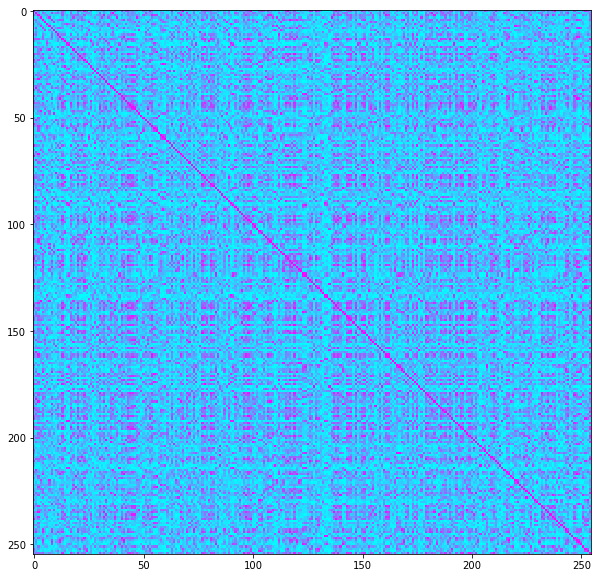

In [9]:

fig, ax = plt.subplots(figsize=(10,10))
img = ax.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='cool', aspect='auto')
plt.show()